In [2]:
import arrow
import copy
import cmocean.cm as cm
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from salishsea_tools import rivertools, nc_tools, viz_tools
from salishsea_tools import river_sss150 as rivers

prop_dict_name ='river_sss150'

%matplotlib inline

In [3]:
cm_deep = copy.copy(cm.deep)
cm_deep.set_bad('grey')
cm_deep.set_under('grey')

In [4]:
# what coordinates are you using?
coords_file = '../../../grid/sss150/coordinates_sss150_20210709.nc'
# where is the river information? 
prop_dict = rivers.prop_dict

In [5]:
#get dimensions for netcdf files
fB = xr.open_dataset(coords_file, decode_times=False)
fB

<xarray.Dataset>
Dimensions:  (x: 710, y: 826)
Dimensions without coordinates: x, y
Data variables: (12/18)
    nav_lon  (y, x) float32 ...
    nav_lat  (y, x) float32 ...
    glamt    (y, x) float64 ...
    glamu    (y, x) float64 ...
    glamv    (y, x) float64 ...
    glamf    (y, x) float64 ...
    ...       ...
    e1v      (y, x) float64 ...
    e1f      (y, x) float64 ...
    e2t      (y, x) float64 ...
    e2u      (y, x) float64 ...
    e2v      (y, x) float64 ...
    e2f      (y, x) float64 ...
Attributes:
    parent_grid:  coordinates_salishseaplaceholder500.nc
    parent_zoom:  imin, imax, jmin, jmax = 1071, 1301, 371, 645
    parent_rho:   3
    note:         This is coordinates_southsalishsea150.nc with an expansion ...

In [6]:
lat = fB['nav_lat'][:]
lon = fB['nav_lon'][:]
e1t = fB['e1t'][:]
e2t = fB['e2t'][:]
horz_area = e1t*e2t
fB.close()

In [7]:
#list of watersheds we are including
names = ['howe', 'fraser']

In [35]:
# Constant and data ranges etc
year = 2023
syear = 2023
smonth = 2
emonth = 2
startdate = arrow.get(year, smonth, 24)
enddate = arrow.get(syear, emonth, 24)
print (startdate, enddate)

2023-02-24T00:00:00+00:00 2023-02-24T00:00:00+00:00


In [33]:
maindir = '/results/forcing/rivers/observations/'
origdir = '/data/dlatorne/SOG-projects/SOG-forcing/ECget/'
def getdir(river_name):
    if river_name in ['Fraser', 'Englishman']:
        thedir = origdir
    elif river_name in ['Capilano_intake']:
        thedir = 'river_flows/'
    else:
        thedir = maindir
    return (thedir)

In [10]:
def read_river(river_name, ps):
    thedir = getdir(river_name)
    river_flow = pd.read_csv(f'{thedir}/{river_name}_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    river_flow['date'] = pd.to_datetime(river_flow.drop(columns='flow'))
    river_flow.set_index('date', inplace=True)
    river_flow = river_flow.drop(columns=['year', 'month', 'day'])
    river_flow = river_flow.dropna(axis=0)  # remove any rows with nans
    if ps == 'primary':
        river_flow = river_flow.rename(columns={'flow': 'Primary River Flow'})
    elif ps == 'secondary':
        river_flow = river_flow.rename(columns={'flow': 'Secondary River Flow'})
    return river_flow

In [11]:
def read_river_Theodosia():
    part1 = pd.read_csv(f'{maindir}/Theodosia_Scotty_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    part2 = pd.read_csv(f'{maindir}/Theodosia_Bypass_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    part3 = pd.read_csv(f'{maindir}/Theodosia_Diversion_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    for part in [part1, part2, part3]:
        part['date'] = pd.to_datetime(part.drop(columns='flow'))
        part.set_index('date', inplace=True)
        part.drop(columns=['year', 'month', 'day'], inplace=True)
    part1 = part1.rename(columns={'flow': 'Scotty'})
    part2 = part2.rename(columns={'flow': 'Bypass'})
    part3 = part3.rename(columns={'flow': 'Diversion'})
    theodosia = (part3.merge(part2, how='inner', on='date')).merge(part1, how='inner', on='date')
    theodosia['Secondary River Flow'] = theodosia['Scotty'] + theodosia['Diversion'] - theodosia['Bypass']
    part3['FlowFromDiversion'] = part3.Diversion * theodosia_from_diversion_only
    theodosia = theodosia.merge(part3, how='outer', on='date', sort=True)
    theodosia['Secondary River Flow'] = theodosia['Secondary River Flow'].fillna(
        theodosia['FlowFromDiversion'])
    return theodosia

In [12]:
def do_a_pair(water_shed, watershed_from_river, startdate, enddate,
              primary_river_name, use_secondary, 
              secondary_river_name='Null', subtract_primary=False):
    primary_river = read_river(primary_river_name, 'primary')
    print (primary_river_name, 'into gaps')
    good, fillit = check_for_gaps(primary_river_name, primary_river['Primary River Flow'], startdate, enddate)
    if not good:
        print ('filling', primary_river_name)
        myfill = fillit[fillit.index > np.datetime64(dt.datetime(2001, 12, 31))]
        fillitd = pd.DataFrame(index = myfill.index, data = {'Primary River Flow': myfill})
        primary_river = primary_river.append(fillitd)
        primary_river = primary_river.sort_index()
        primary_river.index.name = 'date'
            
    if use_secondary:
        print(secondary_river_name, 'read and check')
        if secondary_river_name == "Theodosia":
            secondary_river = read_river_Theodosia()
            
        else:
            secondary_river = read_river(secondary_river_name, 'secondary')
        good, fillit = check_for_gaps(secondary_river_name, secondary_river['Secondary River Flow'], 
                                      startdate, enddate)
        if not good:
            print ('filling', secondary_river_name)
            myfill = fillit[fillit.index > np.datetime64(dt.datetime(2001, 12, 31))]
            fillitd = pd.DataFrame(index = myfill.index, data = {'Secondary River Flow': myfill})
            secondary_river = secondary_river.append(fillitd)
            secondary_river = secondary_river.sort_index()
            secondary_river.index.name = 'date'
                        
        print (secondary_river.index.name, 'Second')        
        rivers = primary_river.merge(secondary_river, how='inner', on='date')
        rivers['Daily Flow'] = (rivers['Primary River Flow'] * 
                        watershed_from_river[water_shed]['primary']
                        + rivers['Secondary River Flow'] 
                        * watershed_from_river[water_shed]['secondary'])
    else:
        rivers = primary_river
        rivers['Daily Flow'] = (primary_river['Primary River Flow'] * 
                                watershed_from_river[water_shed]['primary'])

    
    return rivers

In [13]:
def do_fraser(watershed_from_river, startdate, enddate,
              primary_river_name, secondary_river_name):
    primary_river = read_river(primary_river_name, 'primary')
    good, fillit = check_for_gaps(primary_river_name, primary_river['Primary River Flow'], startdate, enddate)
    if not good:
        print ('filling', primary_river_name)
        myfill = fillit[fillit.index > np.datetime64(dt.datetime(2006, 12, 31))]
        fillitd = pd.DataFrame(index = myfill.index, data = {'Primary River Flow': myfill})
        primary_river = primary_river.append(fillitd)
        primary_river = primary_river.sort_index()
            
    secondary_river = read_river(secondary_river_name, 'secondary')
    good, fillit = check_for_gaps(secondary_river_name, secondary_river['Secondary River Flow'], 
                                      startdate, enddate)
    if not good:
        print ('filling', secondary_river_name)
        myfill = fillit[fillit.index > np.datetime64(dt.datetime(2006, 12, 31))]
        fillitd = pd.DataFrame(index = myfill.index, data = {'Secondary River Flow': myfill})
        secondary_river = secondary_river.append(fillitd)
        secondary_river = secondary_river.sort_index()
        secondary_river.index.name = 'date'
                        
    Fraser = primary_river.merge(secondary_river, how='inner', on='date')
    Fraser['Daily Flow'] = (Fraser['Primary River Flow'] * 
                        watershed_from_river['fraser']['primary']
                        + Fraser['Secondary River Flow'] 
                        * watershed_from_river['fraser']['secondary'] *
                           watershed_from_river['fraser']['nico_into_fraser'])
    secondary_river['Daily Flow'] = (secondary_river['Secondary River Flow'] *
                                      watershed_from_river['fraser']['secondary'] *
                           (1 - watershed_from_river['fraser']['nico_into_fraser']))

    print ('Fraser done')
    return Fraser, secondary_river

In [14]:
def check_for_gaps(name, flows, startdate, enddate):
    subset = flows[(flows.index <= enddate.naive) & (flows.index >= startdate.naive)]
    print (name, len(subset.index), 'index count')
    if subset.isnull().values.any():
        print ('dates in file with missing data', name)
        stop
    diffy = subset.index[1:] - subset.index[:-1]
    day = dt.datetime(2020, 1, 2) - dt.datetime(2020, 1, 1)
    gaps = subset[1:][diffy > day] # gaps marks the day after the gap
    print (gaps, 'gaps')
    print (diffy[diffy > day], 'diffy')
    gap_length = diffy[diffy > day] - day   # correct the gap length
    print (gap_length, 'gap_length')
    if len(gap_length) == 0:   # checking the number of gaps, not the actual value of the gap length
        print ('into good')
        good = True
        fillit = pd.Series(dtype='float64')
    else:
        good = False
        print ('got a gap', name, gaps)
        fillvalue, filldate = patch_gaps(name, flows, gaps, gap_length, day)
        fillit = pd.Series(fillvalue, index=filldate)

    return good, fillit    

In [26]:
matching_dictionary = {'Englishman': 'Salmon_Sayward',
                      'Theodosia': 'Clowhom_ClowhomLake',
                      'RobertsCreek': 'Englishman',
                      'Salmon_Sayward': 'Englishman',
                      'Squamish_Brackendale': 'Homathko_Mouth',
                      'SanJuan_PortRenfrew': 'Englishman',
                      'Nisqually_McKenna': 'Snohomish_Monroe',
                      'Snohomish_Monroe': 'Skagit_MountVernon',
                      'Skagit_MountVernon': 'Snohomish_Monroe',
                      'Homathko_Mouth': 'Squamish_Brackendale',
                      'Nicomekl_Langley': 'RobertsCreek',
                      'Greenwater_Greenwater': 'Snohomish_Monroe',
                      'Clowhom_ClowhomLake': 'Theodosia_Diversion'}
backup_dictionary = {'SanJuan_PortRenfrew': 'RobertsCreek',
                    'Theodosia': 'Englishman'}

In [16]:
def patch_gaps(name, flows, gaps, gap_length, day):
    print ('into patch')
    firstchoice = read_river(matching_dictionary[name], 'primary')
    print ('First Choice', matching_dictionary[name])
    if name in backup_dictionary:
        backup = read_river(backup_dictionary[name], 'primary')
        print ('Backup', backup_dictionary[name])
        ubackup = True
    else:
        ubackup = False
    fillvalue = np.zeros((len(gaps.index), gap_length.max().days))
    filldate = np.zeros((len(gaps.index), gap_length.max().days), dtype='datetime64[ns]')
    for ig, gap in enumerate(gaps.index):
        print ( gap, gap_length[ig], -2*gap_length[ig]+gap-day,  
               gap_length[ig]+gap, 3*gap_length[ig] + 2*day)
        print (len(firstchoice[(firstchoice.index >= -2*gap_length[ig]+gap-day) 
                   & (firstchoice.index <= gap_length[ig]+gap)]))
        if len(firstchoice[(firstchoice.index >= -2*gap_length[ig]+gap-day) 
               & (firstchoice.index <= gap_length[ig]+gap)]) < (3*gap_length[ig] + 2*day).days:
            if ubackup:
                filler = backup
                print (f'Using backup {backup_dictionary[name]}')
                havefill = True
            else:
                havefill = False
        else:
            filler = firstchoice
            print (f'Using firstchoice {matching_dictionary[name]}')
            havefill = True
            
        if havefill:
            summit = 0
            sumsq = 0
            count = 0
            for deltat in np.arange(-2*gap_length[ig]-day, gap_length[ig]+day, day):
                print (filler[filler.index == gap+deltat]['Primary River Flow'].values, 'values')
                summit = summit + filler[filler.index == gap+deltat]['Primary River Flow'].values
                sumsq = sumsq + filler[filler.index == gap+deltat]['Primary River Flow'].values**2
                count = count + 1
            mean = summit/count
            var = sumsq/count - mean**2
            print (count, mean, np.sqrt(var), 'primary')

            sumratio = 0
            sumratio2 = 0
            count = 0
            for deltat in np.arange(-2*gap_length[ig]-day, -gap_length[ig], day):
                ratio = (flows[flows.index == gap+deltat].values /
                        filler[filler.index == gap+deltat]['Primary River Flow'].values)
                print (ratio, 'ratio1')
                if (len(ratio) > 0):
                    sumratio = sumratio + ratio
                    sumratio2 = sumratio2 + ratio**2
                    count = count + 1

            for deltat in np.arange(0, gap_length[ig]+day, day):
                ratio = (flows[flows.index == gap+deltat].values /
                        filler[filler.index == gap+deltat]['Primary River Flow'].values)
                print (ratio, 'ratio2')

                if (len(ratio) > 0):
                    sumratio = sumratio + ratio
                    sumratio2 = sumratio2 + ratio**2
                    count = count + 1

            meanratio = sumratio/count
            varratio = sumratio2/count - meanratio**2
            print (count, meanratio, np.sqrt(varratio), sumratio2/count, 'compare')
            print (np.sqrt(var)/mean, np.sqrt(varratio)/meanratio)

            if count == 0 or np.sqrt(var)/mean < np.sqrt(varratio)/meanratio : 
                uselinear = True
            else:
                uselinear = False
            print (uselinear, 'use linear')
            
        else:
            uselinear = True
        
        print (np.arange(-gap_length[ig], day, day))
        for step, deltat in enumerate(np.arange(-gap_length[ig], 0, day)):
            if uselinear:
                slope = (flows[flows.index == gap].values 
                 - flows[flows.index == gap-day-gap_length[ig]].values)/(gap_length[ig].days+1)
                fillvalue[ig, step] = flows[flows.index == gap-day-gap_length[ig]] + slope * (step+1)
                print (flows[flows.index == gap].values, flows[flows.index == gap-day-gap_length[ig]].values,
                       fillvalue[ig, step])
            else:
                print ('meanratio', meanratio, filler.index == gap + deltat)
                fillvalue[ig, step] = meanratio * filler[filler.index == gap + deltat].values 
            filldate[ig, step] = gap + deltat
    print ('filled with', filldate, fillvalue)
    return fillvalue.flatten(), filldate.flatten()

In [27]:
watershed_from_river = {
    'bute': {'primary': 2.015},
    'jervis': {'primary': 8.810, 'secondary': 140.3},
#    'howe': {'primary': 2.276},
    'howe' : {'primary': 1.653,'secondary': 6.030},
    'jdf': {'primary': 8.501},
    'evi_n': {'primary': 10.334},
    'evi_s': {'primary': 24.60},
    'toba': {'primary': 0.4563, 'secondary': 14.58},
    'skagit': {'primary': 1.267, 'secondary': 1.236},
    'puget': {'primary': 8.790, 'secondary': 29.09},
    'fraser' : {'primary': 1.161, 'secondary': 162, 'nico_into_fraser': 0.83565}
}
rivers_for_watershed = {
    'bute': {'primary': 'Homathko_Mouth',
            'secondary': 'False'},
    'evi_n': {'primary': 'Salmon_Sayward',
             'secondary': 'False'},
    'jervis': {'primary': 'Clowhom_ClowhomLake',
              'secondary': 'RobertsCreek'},
    'evi_s': {'primary': 'Englishman', 
             'secondary': 'False'},
    'howe': {'primary': 'Squamish_Brackendale',
            'secondary': 'Capilano_intake'},
    'jdf': {'primary': 'SanJuan_PortRenfrew',
           'secondary': 'False'},
    'skagit': {'primary': 'Skagit_MountVernon',
              'secondary': 'Snohomish_Monroe'},
    'puget': {'primary': 'Nisqually_McKenna',
             'secondary': 'Greenwater_Greenwater'},
    'toba': {'primary': 'Homathko_Mouth',
            'secondary': 'Theodosia'},
    'fraser': {'primary': 'Fraser',
              'secondary': 'Nicomekl_Langley'},
}

fraserratio = rivers.prop_dict['fraser']['Fraser']['prop']

theodosia_from_diversion_only = 1.429 # see TheodosiaWOScotty

In [20]:
def write_file(day, runoff):
    "keep it small and simple, runoff only"
    notebook = 'MakeDailyRiverNCfiles_sss150.ipynb'
    coords = {
        'x' : range(horz_area.shape[1]),
        'y' : range(horz_area.shape[0]),
        'time_counter' : [0],
    }
    var_attrs = {'units': 'kg m-2 s-1',
                      'long_name': 'runoff_flux'}
    
    year = day.year
    month = day.month
    day = day.day
    # set up filename to follow NEMO conventions
    filename = f'ncfiles/R_sss150_Dailies_y{year}m{month:02}d{day:02}.nc'
    print (filename)
        
    netcdf_title = f'Rivers for y{year}m{month:02}d{day:02}'
    ds_attrs = {
        'acknowledgements':
            'Based on river fit',
        'creator_email':
            'sallen@eoas.ubc.ca',
        'creator_name':
            'Salish Sea MEOPAR Project Contributors',
        'creator_url':
            'https://salishsea-meopar-docs.readthedocs.org/',
        'institution':
            'UBC EOAS',
        'institution_fullname': (
            'Earth, Ocean & Atmospheric Sciences,'
            ' University of British Columbia'
        ),
        'title': netcdf_title,
        'notebook': notebook,
        'rivers_base': prop_dict_name,
        'summary': f'Daily Runoff for sss150 Bathymetry',
        'history': (
            '[{}] File creation.'
            .format(dt.datetime.today().strftime('%Y-%m-%d'))
        )
        }
    runoffs = np.empty((1, runoff.shape[0], runoff.shape[1]))
    runoffs[0] = runoff

    da = xr.DataArray(
            data = runoffs,
            name='rorunoff',
            dims=('time_counter', 'y', 'x'),
            coords = coords,
            attrs = var_attrs)
    

    ds = xr.Dataset(
            data_vars={
            'rorunoff': da},
            coords = coords,
            attrs = ds_attrs
        )
    
    encoding = {var: {'zlib': True} for var in ds.data_vars}

    ds.to_netcdf(filename, unlimited_dims=('time_counter'),
            encoding=encoding,)


In [36]:
flows = {}
for name in names:
    print (name)
    if rivers_for_watershed[name]['secondary'] == 'False':
        print ('no secondary')
        flows[name] = do_a_pair(name, watershed_from_river, startdate, enddate, 
                                rivers_for_watershed[name]['primary'], False)
    elif name == 'fraser':
        flows['Fraser'], flows['nonFraser'] = do_fraser(watershed_from_river, startdate, enddate,
                               rivers_for_watershed[name]['primary'],
                               rivers_for_watershed[name]['secondary'])
    else:
        flows[name] = do_a_pair(name, watershed_from_river, startdate, enddate,
                                rivers_for_watershed[name]['primary'], True,
                               rivers_for_watershed[name]['secondary'])

print ('files read')
for day in arrow.Arrow.range('day', startdate, enddate):
    print (horz_area.shape)
    runoff = np.zeros((horz_area.shape[0], horz_area.shape[1]))
    run_depth = np.ones_like(runoff)
    run_temp = np.empty_like(runoff)
    for name in names:
        print (name)
        if name == 'fraser':
            for key in prop_dict[name]:
                if "Fraser" in key:
                    flux = flows['Fraser'][flows['Fraser'].index == day.naive]['Daily Flow'][0]
                    subarea = fraserratio
                else:
                    flux = flows['nonFraser'][flows['nonFraser'].index == day.naive]['Daily Flow'][0]
                    subarea = 1 - fraserratio
        
                river = prop_dict['fraser'][key]
                runoff = rivertools.fill_runoff_array(flux*river['prop']/subarea, river['i'],
                          river['di'], river['j'], river['dj'], river['depth'], runoff, 
                          run_depth, horz_area)[0]
        else:
            flowtoday = flows[name][flows[name].index == day.naive]['Daily Flow'][0]
            runoff, run_depth, run_temp = rivertools.put_watershed_into_runoff('constant', horz_area,
                                            flowtoday, runoff, run_depth, run_temp,
                                            prop_dict[name])
            
    write_file(day, runoff)

howe
Squamish_Brackendale into gaps
Squamish_Brackendale 1 index count
Series([], Name: Primary River Flow, dtype: float64) gaps
TimedeltaIndex([], dtype='timedelta64[ns]', name='date', freq=None) diffy
TimedeltaIndex([], dtype='timedelta64[ns]', name='date', freq=None) gap_length
into good
Capilano_intake read and check
Capilano_intake 2 index count
Series([], Name: Secondary River Flow, dtype: float64) gaps
TimedeltaIndex([], dtype='timedelta64[ns]', name='date', freq=None) diffy
TimedeltaIndex([], dtype='timedelta64[ns]', name='date', freq=None) gap_length
into good
date Second
fraser
Fraser 1 index count
Series([], Name: Primary River Flow, dtype: float64) gaps
TimedeltaIndex([], dtype='timedelta64[ns]', name='date', freq=None) diffy
TimedeltaIndex([], dtype='timedelta64[ns]', name='date', freq=None) gap_length
into good
Nicomekl_Langley 1 index count
Series([], Name: Secondary River Flow, dtype: float64) gaps
TimedeltaIndex([], dtype='timedelta64[ns]', name='date', freq=None) diff

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:518: UserWarning: Attempting to set identical left == right == 19358.0 results in singular transformations; automatically expanding.
  ax.set_xlim(self.xlim)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:518: UserWarning: Attempting to set identical left == right == 19358.0 results in singular transformations; automatically expanding.
  ax.set_xlim(self.xlim)


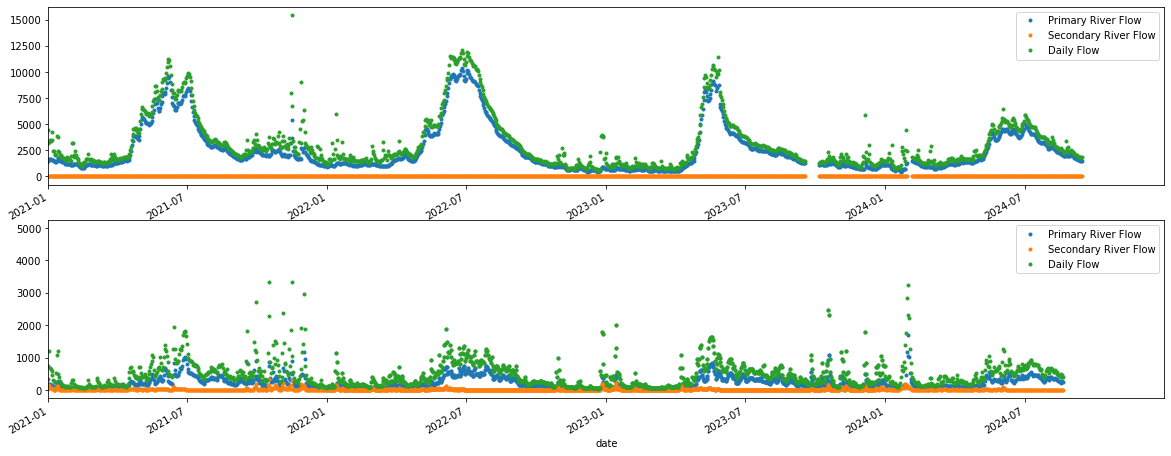

In [29]:
fig, axs = plt.subplots(2, 1, figsize=(20, 8))
flows['Fraser'].plot(ax=axs[0], xlim=(startdate.datetime, enddate.datetime), linewidth=0, marker='.');
flows['howe'].plot(ax=axs[1], xlim=(startdate.datetime, enddate.datetime), linewidth=0, marker='.');

In [30]:
bathy = xr.open_dataset('../../../grid/sss150/bathymetry_sss150_update202108210102AUM1.nc')

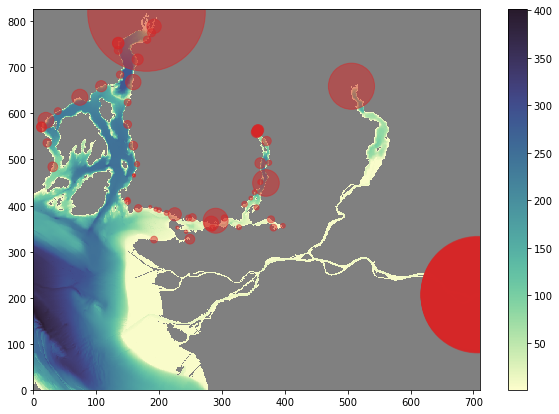

In [31]:
imin, imax = 0, horz_area.shape[0]
jmin, jmax = 0, horz_area.shape[1]
jj = range(jmax)
ii = range(imax)
jjm, iim = np.meshgrid(jj, ii)
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
colours = ax.pcolormesh(bathy.Bathymetry[imin:imax, jmin:jmax], cmap=cm_deep, vmin=0.5)
fig.colorbar(colours)
ax.scatter(jjm[runoff[:, :jmax]>0], iim[runoff[:, :jmax]>0], 
           s=runoff[:, :jmax][runoff[:, :jmax]>0]*1000, color='tab:red', alpha=0.5);